# Weather Forecasting
            1. Slicing dataset 
            2. Data Pre-processing
            3. Visualize the Time Series Data
            4. Plot the correlation and AutoCorrelation Charts
            4. Consruct the ARIMA model and SARIMA based on the data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.stattools import adfuller 
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima_model import ARIMA
from math import sqrt
from pmdarima import auto_arima





In [2]:
df=pd.read_csv('Denawaka_project.csv')
df.head()




,Year,Month,Rainfall,Temp_min,Temp_max,Hum_min,Hum_max
0,2010,January,233.6,22.1,32.1,NaN,NaN
1,2010,February,111.9,22.6,33.9,NaN,NaN
2,2010,March,157.5,23.1,35.2,NaN,NaN
3,2010,April,438.3,23.7,33.5,NaN,NaN
4,2010,May,658.5,24.0,31.8,NaN,NaN


In [3]:
df["Time"]=df["Year"].astype(str)+"-"+df["Month"].astype(str)




In [4]:
#Creating time column
df['Time'] = pd.to_datetime(df['Time'])

In [5]:
df.head()


,Year,Month,Rainfall,Temp_min,Temp_max,Hum_min,Hum_max,Time
0,2010,January,233.6,22.1,32.1,NaN,NaN,2010-01-01
1,2010,February,111.9,22.6,33.9,NaN,NaN,2010-02-01
2,2010,March,157.5,23.1,35.2,NaN,NaN,2010-03-01
3,2010,April,438.3,23.7,33.5,NaN,NaN,2010-04-01
4,2010,May,658.5,24.0,31.8,NaN,NaN,2010-05-01


In [6]:
rainfall=df[["Time","Rainfall"]]
rainfall.head()



,Time,Rainfall
0,2010-01-01,233.6
1,2010-02-01,111.9
2,2010-03-01,157.5
3,2010-04-01,438.3
4,2010-05-01,658.5


Slicing dataset into different time series

#                                        Forecasting rainfall

In [7]:
#Checking for missing values
rainfall.isna().sum()


Time        0
Rainfall    0
dtype: int64

In [8]:
#removing missing values
rain=rainfall.dropna(how="any")
rain.head()



,Time,Rainfall
0,2010-01-01,233.6
1,2010-02-01,111.9
2,2010-03-01,157.5
3,2010-04-01,438.3
4,2010-05-01,658.5


In [9]:
rain.set_index('Time',inplace=True)


#  Visualize the Data

<AxesSubplot:xlabel='Time'>

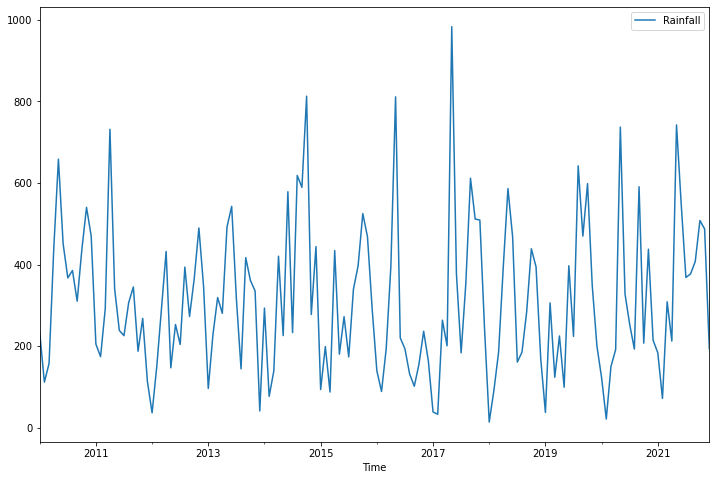

In [10]:
rain.plot(figsize=(12,8))


No significant trend. But it can be seen that there is some evidence for seasonality. 

# Testing For Stationarity

In [11]:
### ADF Test
test_result=adfuller(rain['Rainfall'])
#Ho: The series is non stationary
#H1: The series is stationary

def adfuller_test(rainfall):
    result=adfuller(rainfall)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
    
adfuller_test(rain['Rainfall'])


ADF Test Statistic : -3.8900473048005555
p-value : 0.0021093267289122213
#Lags Used : 13
Number of Observations Used : 130
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


In [12]:
# KPSS test
from statsmodels.tsa.stattools import kpss
def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

kpss_test(rain['Rainfall'])


KPSS Statistic: 0.04129100763562834
p-value: 0.1
num lags: 4
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


C:\Users\isuru\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [13]:
#PhillipsPerron Test
from arch.unitroot import PhillipsPerron

pp = PhillipsPerron(rain['Rainfall'])
print(pp.summary().as_text())


     Phillips-Perron Test (Z-tau)    
Test Statistic                 -8.526
P-value                         0.000
Lags                               14
-------------------------------------

Trend: Constant
Critical Values: -3.48 (1%), -2.88 (5%), -2.58 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


# ACF and PACF plots

C:\Users\isuru\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


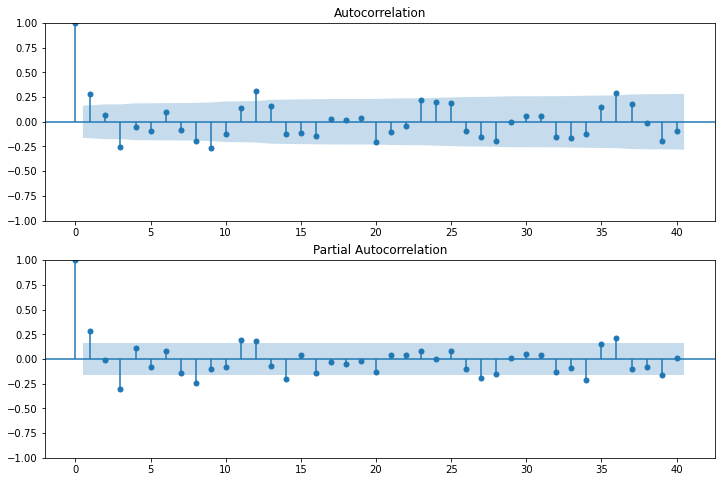

In [14]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(rain['Rainfall'],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(rain['Rainfall'],lags=40,ax=ax2)


Fitting ARMA model

In [15]:
# For non-seasonal data
#According to PACF and ACF plots, p=3 d=0 and q=3 can be considered.
arima_model=auto_arima(rain['Rainfall'].astype(float),start_p=0,start_q=0,max_p=3,max_q=3,start_P=0,start_Q=0,max_P=3,max_Q=3,m=12,seasonal=True,error_action='warn',trace=True,supress_warnings=True,stepwise=True,random_state=20,n_fits=50)


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=1915.059, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=1895.619, Time=0.62 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=1899.203, Time=0.57 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=2108.878, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=1905.415, Time=0.05 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=1896.985, Time=2.96 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=1898.479, Time=0.90 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=1896.700, Time=0.45 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=1899.596, Time=4.44 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=1901.474, Time=0.43 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=1895.247, Time=0.85 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=1907.407, Time=0.16 sec
 ARIMA(2,0,0)(2,0,0)[12] intercept   : AIC=1896.032, Time=4.13 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : AIC=1899.573, Time=1.17 sec
 ARIMA(2,0,0)(0,0,1

Fitting SARIMA model

In [16]:
model=sm.tsa.statespace.SARIMAX(rain['Rainfall'].astype('float'),order=(1,0,2),seasonal_order=(1,0,0,12))
results=model.fit()
results.summary()


C:\Users\isuru\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\isuru\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                            Rainfall   No. Observations:                  144
Model:             SARIMAX(1, 0, 2)x(1, 0, [], 12)   Log Likelihood                -948.093
Date:                             Wed, 13 Apr 2022   AIC                           1906.186
Time:                                     23:23:49   BIC                           1921.035
Sample:                                 01-01-2010   HQIC                          1912.220
                                      - 12-01-2021                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000      0.000   2985.547      0.000       0.999       1.001
ma.L1         -0.8241      0.096     -8.581      0.000      -1.012      -0.636
ma.L2         -0.1683      0.103     -1.636      0.102      -0.370       0.033
ar.S.L12       0.3026      0.072      4.208      0.000       0.162       0.443
sigma2      2.935e+04   7.87e-07   3.73e+10      0.000    2.94e+04    2.94e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.28   Jarque-Bera (JB):                22.00
Prob(Q):                              0.60   Prob(JB):                         0.00
Heteroskedasticity (H):               1.39   Skew:                             0.90
Prob(H) (two-sided):                  0.26   Kurtosis:                         3.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.05e+26. Standard errors may be unstable.
"""

# Forecast rainfall using the model

<AxesSubplot:xlabel='Time'>

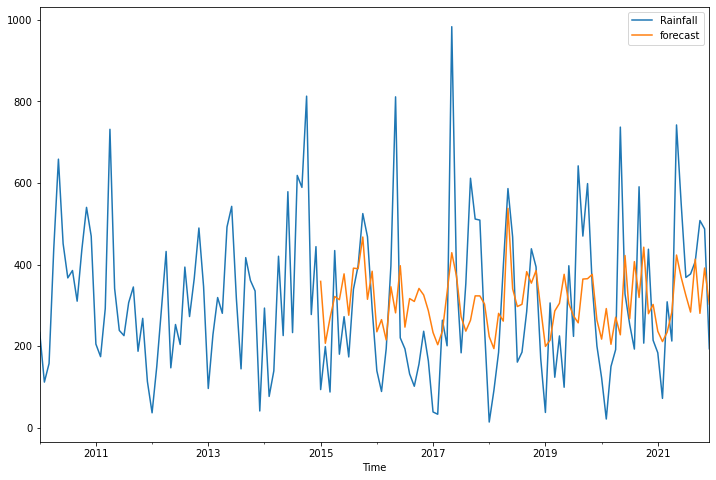

In [17]:
rain['forecast']=results.predict(start='2015-01-01',end='2025-01-01',dynamic=False)
rain[['Rainfall','forecast']].plot(figsize=(12,8))


In [18]:
rain.tail()

,Rainfall,forecast
Time,,
2021-08-01,377.1,283.598202
2021-09-01,407.7,413.187948
2021-10-01,508.0,280.501772
2021-11-01,487.4,391.572652
2021-12-01,193.7,302.873426


In [80]:
results.predict(start='2010-01-01',end='2025-01-01',dynamic=False)

C:\Users\wasan\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


2010-01-01      0.000000
2010-02-01    181.182005
2010-03-01    134.617875
2010-04-01    152.259370
2010-05-01    257.714409
                 ...    
2024-09-01    318.939183
2024-10-01    321.711365
2024-11-01    321.134810
2024-12-01    312.993822
2025-01-01    314.770800
Freq: MS, Name: predicted_mean, Length: 181, dtype: float64